In [90]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


%matplotlib widget

In [91]:
#get data function
def getdata(path):
    df_iris = pd.read_csv(path)
    X = df_iris.iloc[:,1:5].values
    X = torch.tensor(X, dtype=torch.float32)
    enc = LabelEncoder()
    y = enc.fit_transform(df_iris.Species)
    y = torch.from_numpy(y).type(torch.LongTensor)

    return X, y

def data_split(X,y, batch_size):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    test = TensorDataset(X_test, y_test)
    X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    train = TensorDataset(X_training, y_training)
    val = TensorDataset(X_val, y_val)

    #data loader
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

    print(f'train size: {X_training.shape}, val size: {X_val.shape}, test size: {X_test.shape}')
    print(f'train num bacthes: {len(train_loader)}, val : {len(val_loader)}, test : {len(test_loader)}')
    return train_loader, val_loader, test_loader

In [92]:
#define the model
class Dlnn(nn.Module):
    def __init__(self,input_dim, hiddin_dim, output_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            #1st hidden layer
            nn.Linear(input_dim, hiddin_dim),
            nn.ReLU(),
            #2nd hidden layer
            nn.Linear(hiddin_dim, hiddin_dim),
            nn.ReLU(),
            #3rd hidden layer
            nn.Linear(hiddin_dim, output_dim),
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [93]:
#train the model
def train_model(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for count, (X, y) in enumerate(dataloader):
        #compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss +=loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if (count+1) % 5 == 0:
            loss, current = loss.item(), count * batch_size + len(X)
            print(f'loss: {loss} [{current}/{size}]')
            
    train_loss /= num_batches
    correct /= size
    print(f'Train: Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss}')
        

In [94]:
def test_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f'Test: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss}')    
    return test_loss, correct

    

In [95]:
#define the hyperparameter
learning_rate = 1e-3
epochs = 5
input_dim = 4
hidden_dim = 64
output_dim = 3

model = Dlnn(input_dim, hidden_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

In [96]:
#run the program
path = '../MachineL/data/Iris.csv'
X,y = getdata(path)
batch_size=5
train, val, test = data_split(X,y, batch_size)

test_loss_hist, test_acc_hist, epoch_list = [],[],[]
epochs = 30
for t in range(epochs):
    print(f'Epoch {t+1}\n------------------------------')
    train_model(train, model, loss_fn, optimizer, batch_size)
    loss, accuracy = test_model(val, model, loss_fn)
    test_loss_hist.append(loss)
    test_acc_hist.append(accuracy)
    epoch_list.append(t)

print('done!')


train size: torch.Size([96, 4]), val size: torch.Size([24, 4]), test size: torch.Size([30, 4])
train num bacthes: 20, val : 5, test : 6
Epoch 1
------------------------------
loss: 0.9492875337600708 [25/96]
loss: 0.9831783175468445 [50/96]
loss: 0.9036319851875305 [75/96]
loss: 1.0696316957473755 [96/96]
Train: Accuracy: 34.4%, Avg loss: 1.017971158027649
Test: Accuracy: 45.8%, Avg loss: 0.9900393843650818
Epoch 2
------------------------------
loss: 0.8303394317626953 [25/96]
loss: 0.8002829551696777 [50/96]
loss: 0.8754180669784546 [75/96]
loss: 0.7868140935897827 [96/96]
Train: Accuracy: 68.8%, Avg loss: 0.8554526567459106
Test: Accuracy: 54.2%, Avg loss: 0.8759062170982361
Epoch 3
------------------------------
loss: 0.748751163482666 [25/96]
loss: 0.6696114540100098 [50/96]
loss: 0.8359752893447876 [75/96]
loss: 0.5936850309371948 [96/96]
Train: Accuracy: 68.8%, Avg loss: 0.7451106905937195
Test: Accuracy: 54.2%, Avg loss: 0.79000004529953
Epoch 4
------------------------------
l

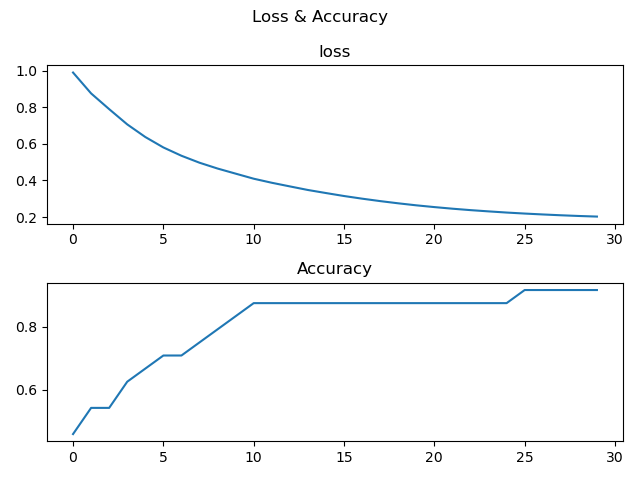

In [97]:
fig, ax = plt.subplots(2)
fig.suptitle('Loss & Accuracy')
ax[0].plot(epoch_list, test_loss_hist)
ax[0].set_title('loss')
ax[1].plot(epoch_list, test_acc_hist)
ax[1].set_title('Accuracy')
fig.tight_layout()
plt.show()